In [66]:
import numpy as np

import sys
import os
sys.path.append(os.path.abspath('../../order_book_simulations'))

from classes.trader import Trader
from classes.order_book import OrderBook
from classes.market_manager import MarketManager

import utilities

import pandas as pd
from matplotlib import pyplot as plt

import statsmodels.api as sm

In [67]:
np.random.seed(700)

In [68]:
# since we want an uptrend, the average market buy volume should be greater than the average limit sell volume
# and the average market sell volume should be lower than the average limit buy volume

prob_informed = 0.02

tick = 1

initial_price = 100
final_payoff = 110
payoff_std = 10

samples_necessary_to_make_decisions = 100
initial_vol = samples_necessary_to_make_decisions


mu_sequence = []
delta_sequence = []

In [69]:
def compute_expected_payoff(book, final_payoff, payoff_std, is_informed):
    if is_informed:
        return final_payoff
    else:
        return book.return_mid_price() + (np.random.choice([-1,1])*book.return_mid_price()/2) #np.random.normal(0, payoff_std)
    
def cancel_order(trader, order_type):
    orders = [order for order in trader.active_orders if order[3] == order_type]
    if orders:
        return orders
    else:
        return None


In [70]:
def compute_ask(V_low, V_high, delta, mu):
    if mu == 1 and delta == 1:
        return V_high
    elif mu == 0 and delta == 0.5:
        return V_high
    else:
        num = V_low * (1 - mu) * delta + V_high * (1 - delta) * (1 + mu)
        den = 1 + mu * (1 - 2*delta)

        return round(num / den, utilities.number_of_decimal_digits(tick))

def compute_bid(V_low, V_high, delta, mu):
    if mu == 1 and delta == 0:
        return V_low
    elif mu == 0 and delta == 0.5:
        return V_low
    else:
        num = V_low * (1 + mu) * delta + V_high * (1 - delta) * (1 - mu)
        den = 1 - mu * (1 - 2*delta)

        return round(num / den, utilities.number_of_decimal_digits(tick))


In [71]:
def market_maker_logic(book, traders, simulation_step, mu, delta):
    tr_id = 'market_maker'
    tr_idx = [index for index, trader in enumerate(traders) if trader.trader_id == tr_id][0]

    order_type = 'limit_buy'
    orders = cancel_order(traders[tr_idx], order_type)

    # don't update lists while cancelling
    if orders is not None:
        for order in orders:
            # cancel the mm bid quotes, since we want to add some new
            traders[tr_idx].submit_order_to_order_book(
                'modify_limit_buy', order[0], order[1], book, simulation_step, verbose=False, update_lists=False
                )

    order_type = 'limit_sell'
    orders = cancel_order(traders[tr_idx], order_type)

    if orders is not None:
        for order in orders:
            # cancel the mm bid quotes, since we want to add some new
            traders[tr_idx].submit_order_to_order_book(
                'modify_limit_sell', order[0], order[1], book, simulation_step, verbose=False, update_lists=False
                ) 

    
    v_low = book.price_sequence[-1] * (1 - (np.exp(mu/2) - 1)) #- tick
    v_high = book.price_sequence[-1] * (1 + (np.exp(mu/2) - 1)) # + tick

    ask_price = compute_ask(v_low, v_high, delta, mu)
    bid_price = compute_bid(v_low, v_high, delta, mu)

    if ask_price == bid_price:
        ask_price = book.price_sequence[-1] + tick #v_high
        bid_price = book.price_sequence[-1] - tick #v_low
        
    # now there are no bid quotes made by the market maker.
    # he will issue a new limit sell
    traders[tr_idx].submit_order_to_order_book(
        'limit_sell', ask_price, initial_vol, book, simulation_step, verbose=False, update_lists=False
        )
    
    
    # now there are no bid quotes made by the market maker.
    # he will issue a new limit buy

    # update lists just at the end of the market maker actions
    traders[tr_idx].submit_order_to_order_book(
        'limit_buy', bid_price, initial_vol, book, simulation_step, verbose=False, update_lists=True
        )
    

    

In [72]:
def trader_logic(prob_informed, traders, book, final_payoff, payoff_std, simulation_step):
# decide if trader is informed or not
    r = np.random.uniform(0,1)
    
    if r < prob_informed:
        # informed trader
        tr_id = 'informed_trader'
        tr_idx = [index for index, trader in enumerate(traders) if trader.trader_id == tr_id][0]
        is_informed = True
    else:
        # uninformed trader
        tr_id = 'uninformed_trader'
        tr_idx = [index for index, trader in enumerate(traders) if trader.trader_id == tr_id][0]
        is_informed = False

    expected_payoff = compute_expected_payoff(book, final_payoff, payoff_std, is_informed)

    best_bid = book.bids[0][0]
    best_ask = book.asks[0][0]

    if (expected_payoff <= best_ask) and (expected_payoff >= best_bid):
        # do nothing
        order_type = 'do_nothing'
    elif expected_payoff > best_ask:
        # mkt buy
        order_type = 'market_buy'
    else:
        # mkt sell
        order_type = 'market_sell'

    traders[tr_idx].submit_order_to_order_book(
        order_type, None, 1, book, simulation_step, verbose=False
        )

In [73]:
class strategy(MarketManager):
    def __init__(self, simulation_length, traders_dict, book: OrderBook):
        super().__init__(simulation_length, traders_dict, book)

        self.mu = 0
        self.delta = 0.5
        self.update_bid_ask = False
        self.counter_before_updating = 0


    def simulate_market(self, simulation_step):    

        mu_sequence.append(self.mu)
        delta_sequence.append(self.delta)
        
        # initialise some bids and asks            
        if simulation_step == 1:
            tr_id = 'market_maker'
            tr_idx = [index for index, trader in enumerate(self.traders) if trader.trader_id == tr_id][0]

            self.traders[tr_idx].submit_order_to_order_book(
                'limit_sell', initial_price + tick, initial_vol, self.book, simulation_step, verbose=False, update_lists=True
                )
        elif simulation_step == 2:
            tr_id = 'market_maker'
            tr_idx = [index for index, trader in enumerate(self.traders) if trader.trader_id == tr_id][0]

            self.traders[tr_idx].submit_order_to_order_book(
                'limit_buy', initial_price - tick, initial_vol, self.book, simulation_step, verbose=False, update_lists=True
                )
        else:
            if (np.isnan(self.book.return_bid_ask_spread())) or self.update_bid_ask:
                # market maker issues a new bid ask spread
                market_maker_logic(self.book, self.traders, simulation_step, self.mu, self.delta)

                self.update_bid_ask = False
            else:
                # traders can act
                trader_logic(prob_informed, self.traders, self.book, final_payoff, payoff_std, simulation_step)

                self.counter_before_updating += 1

                b_t = np.sum(self.book.buy_sequence)
                s_t = np.sum(self.book.sell_sequence)

                if b_t + s_t == 0:
                    fraction_buy_vs_sell = 0
                else:
                    fraction_buy_vs_sell = (b_t - s_t)/ (b_t + s_t)

                if self.counter_before_updating > samples_necessary_to_make_decisions:

                    self.mu = np.abs(fraction_buy_vs_sell)

                    # delta is prob of having a low realization, so I put a -1
                    self.delta = (1 + np.tanh((3*np.pi / 2) * -fraction_buy_vs_sell)) / 2

                    self.counter_before_updating = 0
                    self.update_bid_ask = True
                
    



In [74]:
# generate some orders to have an uptrend, then see how the OFI behaves

book = OrderBook()

mm = strategy(1000, {'market_maker': (initial_price * initial_vol * 5, initial_vol*10,True), 
                     'informed_trader': (initial_price * initial_vol*5, 0,True), 
                     'uninformed_trader': (initial_price * initial_vol *5, 0,True)}
                     , book)

mm.run_market_manager()

In [75]:
#utilities.plot_order_flow(mm.book.book_state_sequence,
#                        price_sequence=mm.book.price_sequence,
#                        volumes_sequence=mm.book.volumes_sequence,
#                        buy_sequence=mm.book.buy_sequence,
#                        sell_sequence=mm.book.sell_sequence,
#                        ticksize=1
#                        )

<Axes: >

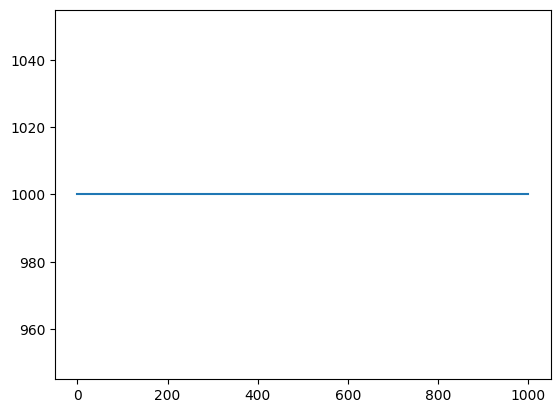

In [76]:
(pd.Series(s[1] for s in mm.traders[0].number_units_stock_in_inventory_sequence
          ) + pd.Series(
              s[1] for s in mm.traders[0].number_units_stock_in_market_sequence) + \
pd.Series(s[1] for s in mm.traders[1].number_units_stock_in_inventory_sequence
          ) + pd.Series(
              s[1] for s in mm.traders[1].number_units_stock_in_market_sequence) + \
pd.Series(s[1] for s in mm.traders[2].number_units_stock_in_inventory_sequence
          ) + pd.Series(
              s[1] for s in mm.traders[2].number_units_stock_in_market_sequence)).plot()

<Axes: >

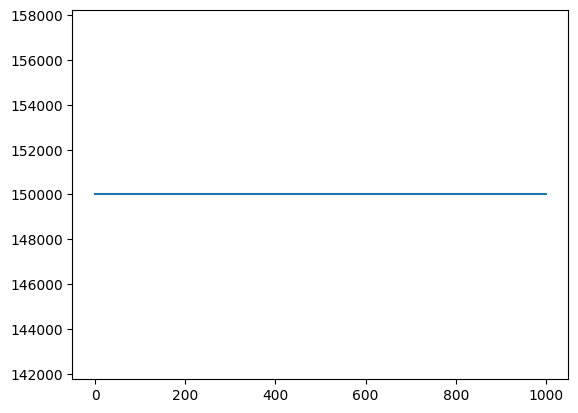

In [77]:
(pd.Series(s[1] for s in mm.traders[0].cash_sequence
          ) + \
pd.Series(s[1] for s in mm.traders[1].cash_sequence
          ) + \
pd.Series(s[1] for s in mm.traders[2].cash_sequence
          )).plot()

In [78]:
total_wealth = mm.traders[0].total_wealth_sequence[-1][1] + \
    mm.traders[1].total_wealth_sequence[-1][1] + \
    mm.traders[2].total_wealth_sequence[-1][1]


total_cash = mm.traders[0].cash_sequence[-1][1] + \
    mm.traders[1].cash_sequence[-1][1] + \
    mm.traders[2].cash_sequence[-1][1]


total_number_of_units = mm.traders[0].number_units_stock_in_inventory_sequence[-1][1] + \
    mm.traders[1].number_units_stock_in_inventory_sequence[-1][1] + \
    mm.traders[2].number_units_stock_in_inventory_sequence[-1][1] + \
    mm.traders[0].number_units_stock_in_market_sequence[-1][1]



total_number_of_units * mm.book.price_sequence[-1] + total_cash == total_wealth


True

In [79]:
df = pd.DataFrame({
    'price': mm.book.price_sequence,
    'market_maker_equity_line': [
        wealth[1] for wealth in mm.traders[0].total_wealth_sequence],
    'informed_trader_equity_line': [
        wealth[1] for wealth in mm.traders[1].total_wealth_sequence],
    'uninformed_trader_equity_line': [
        wealth[1] for wealth in mm.traders[2].total_wealth_sequence],

    'market_maker_cash': [
        cash[1] for cash in mm.traders[0].cash_sequence[1:]],
    'informed_trader_cash': [
        cash[1] for cash in mm.traders[1].cash_sequence[1:]],
    'uninformed_trader_cash': [
        cash[1] for cash in mm.traders[2].cash_sequence[1:]],

    'market_maker_units': [
        units[0][1] + units[1][1] for units in zip(mm.traders[0].number_units_stock_in_inventory_sequence[1:],
                                mm.traders[0].number_units_stock_in_market_sequence[1:])],
    'informed_trader_units': [
        units[1] for units in mm.traders[1].number_units_stock_in_inventory_sequence[1:]],
    'uninformed_trader_units': [
        units[1] for units in mm.traders[2].number_units_stock_in_inventory_sequence[1:]]
    })

Text(0.5, 1.0, 'Price')

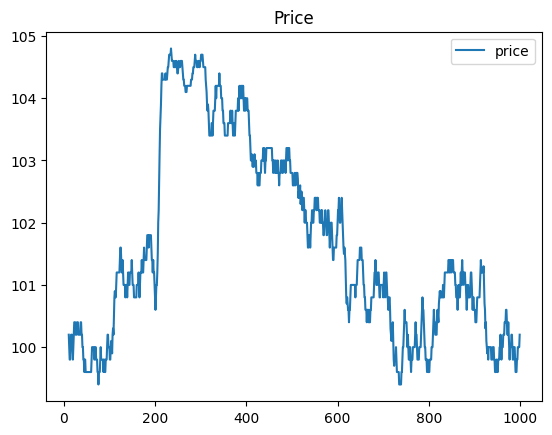

In [80]:
df['price'].rolling(10).mean().plot()
plt.legend()
plt.title('Price')

<Axes: >

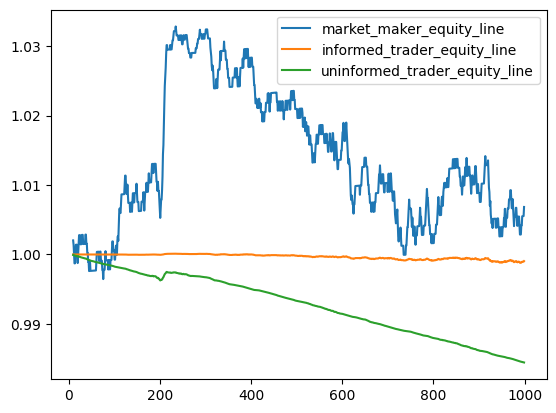

In [81]:
(df[[
    'market_maker_equity_line', 
    'informed_trader_equity_line', 
    'uninformed_trader_equity_line'
    ]].dropna().pct_change().fillna(0) + 1).cumprod().rolling(10).mean().plot()

<Axes: >

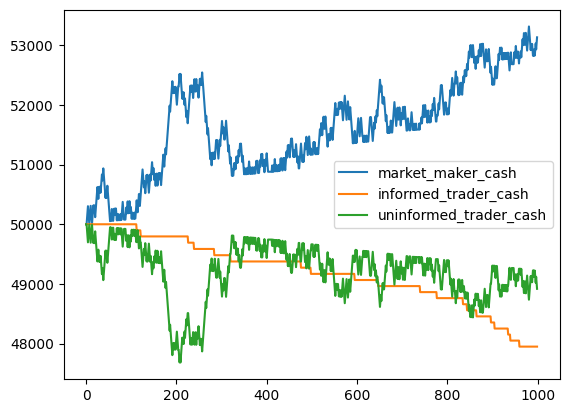

In [82]:
df[[
    'market_maker_cash', 
    'informed_trader_cash', 
    'uninformed_trader_cash'
    ]].plot()

<Axes: >

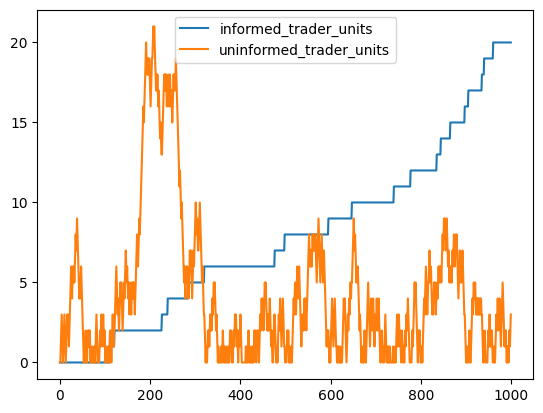

In [83]:
df[[ 
    'informed_trader_units', 
    'uninformed_trader_units'
    ]].plot()

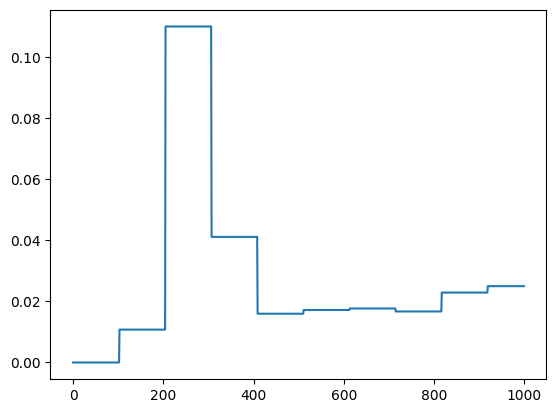

In [84]:
plt.plot(mu_sequence)

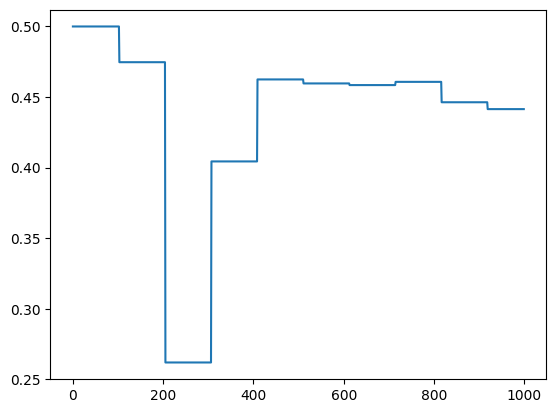

In [85]:
plt.plot(delta_sequence)

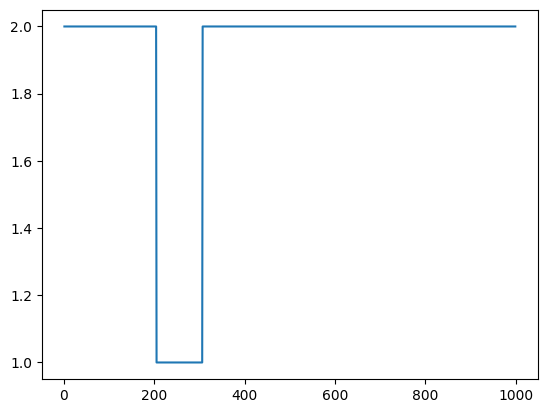

In [86]:
plt.plot(mm.book.bid_ask_spread_sequence)

In [87]:
final_payoff

110

In [92]:
p = (mm.traders[0].number_units_stock_in_inventory_sequence[-1][1] +\
 mm.traders[0].number_units_stock_in_market_sequence[-1][1] \
 ) * final_payoff + mm.traders[0].cash_sequence[-1][1]

i = initial_price * initial_vol * 5 + initial_price *(initial_vol*10)
print(f"Final portfolio value of market maker: {p}, initial value: {i}")

p = (mm.traders[1].number_units_stock_in_inventory_sequence[-1][1] +\
 mm.traders[1].number_units_stock_in_market_sequence[-1][1] \
 ) * final_payoff + mm.traders[1].cash_sequence[-1][1]

i = initial_price * initial_vol * 5
print(f"Final portfolio value of informed trader: {p}, initial value: {i}")


p = (mm.traders[2].number_units_stock_in_inventory_sequence[-1][1] +\
 mm.traders[2].number_units_stock_in_market_sequence[-1][1] \
 ) * final_payoff + mm.traders[2].cash_sequence[-1][1]

i = initial_price * initial_vol * 5
print(f"Final portfolio value of uninformed trader: {p}, initial value: {i}")


Final portfolio value of market maker: 160605.0, initial value: 150000
Final portfolio value of informed trader: 50148.0, initial value: 50000
Final portfolio value of uninformed trader: 49247.0, initial value: 50000
